In [1]:
%matplotlib inline
import sys
import errno
import pandas as pd
import numpy as np
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_pacf
from collections import OrderedDict
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams['figure.figsize'] = [12,8]

Pulls the data from the appropriate url and saves it as a data frame

In [4]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [5]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [6]:
def get_pairs():
    for pair in ['USDT_BTC','USDT_ETH', 'USDT_LTC', 'USDT_DASH', 'BTC_ETH', 'BTC_LTC', 'BTC_DASH']:
        timeSeries = pd.DataFrame()
        df = get_ohlcv_poloniex(pair=pair, start=1483600958, end=9999999999, period=86400)
#         df = df[df.index % 7 == 0]
        df['pct_change'] = df['weightedAverage'].pct_change()
        df['log_ret'] = np.log(df['weightedAverage']) - np.log(df['weightedAverage'].shift(1))
        df[pair] = df['log_ret']
        df = pd.DataFrame(df[pair])
        timeSeries = pd.concat([timeSeries,df], axis=1)
        timeSeries = timeSeries.iloc[1:]
        yield timeSeries, pair
    

In [7]:
def generate_clusters(timeSeries, pair):
    z_euclidean = hac.linkage(timeSeries, method='ward', metric='euclidean'),"Euclidean"
    z_minkowski = hac.linkage(timeSeries, method='ward', metric='minkowski'),"Minowski"
#     z_cityblock = hac.linkage(timeSeries, method='ward', metric='cityblock'),"Cityblock"
#     z_cosine = hac.linkage(timeSeries, method='ward', metric='cosine'),"Cosine"
#     z_correlation = hac.linkage(timeSeries, method='ward', metric='correlation'),"Correlation"

    p = 12
    max_d = 50
    
    for z, name in [z_euclidean]:#,z_minowski,z_cityblock,z_cosine,z_correlation]: 
                                #ValueError: Method 'ward' requires the distance metric to be Euclidean
        print(pair)
        print(name, "/", "Ward")
        fancy_dendrogram(
            z,
            truncate_mode='lastp',
            p=p,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,  # useful in small plots so annotations don't overlap
            max_d=max_d,
        )
        plt.show()
        
        c, coph_dists = cophenet(z, pdist(timeSeries))
        print(name + " Cophenetic Correlation Coefficient: " + str(c))

        print("Euclidean Clusters")
        clusters = fcluster(z, max_d, criterion='distance')
#         plt.figure(figsize=(10, 8))
        ar = np.arange(len(timeSeries))
        plt.scatter(timeSeries[pair], timeSeries[pair], c=clusters, cmap='prism')  # plot points with cluster dependent colors
        plt.show()

In [8]:
def plot_partial_lag(timeSeries, lag):
    plot_pacf(timeSeries, lags=lag)
#     plt.figure(figsize=(10, 8))
    plt.show()

USDT_BTC
Euclidean / Ward


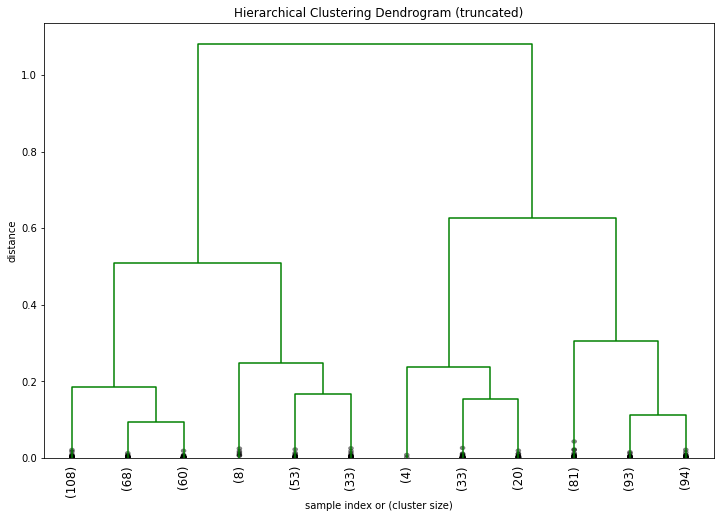

Euclidean Cophenetic Correlation Coefficient: 0.5290151362714419
Euclidean Clusters


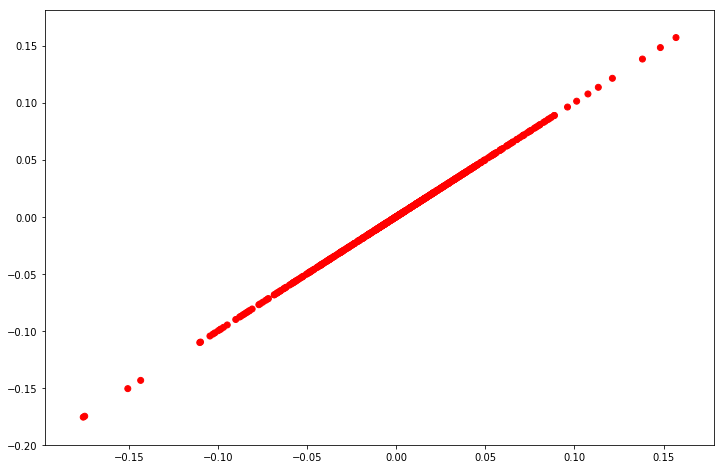

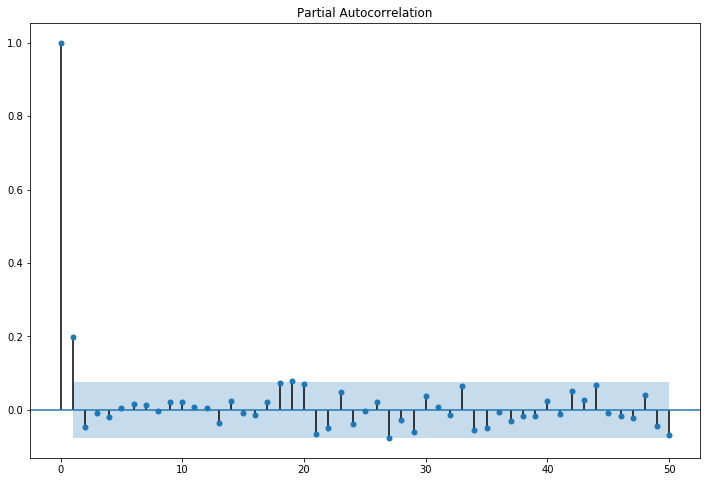

USDT_ETH
Euclidean / Ward


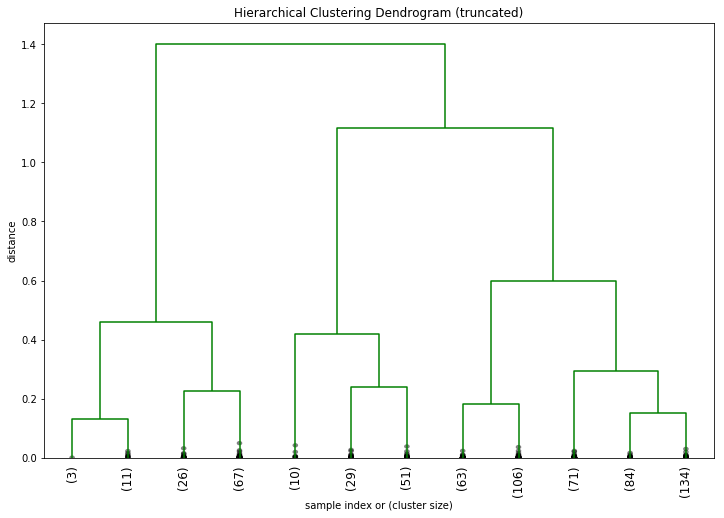

Euclidean Cophenetic Correlation Coefficient: 0.6918798670496001
Euclidean Clusters


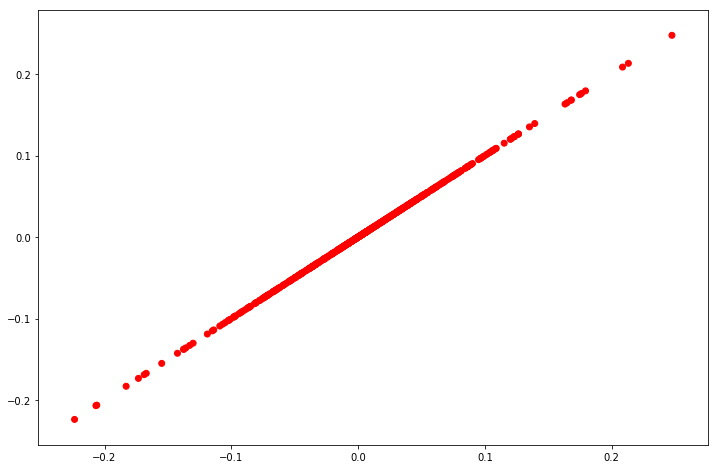

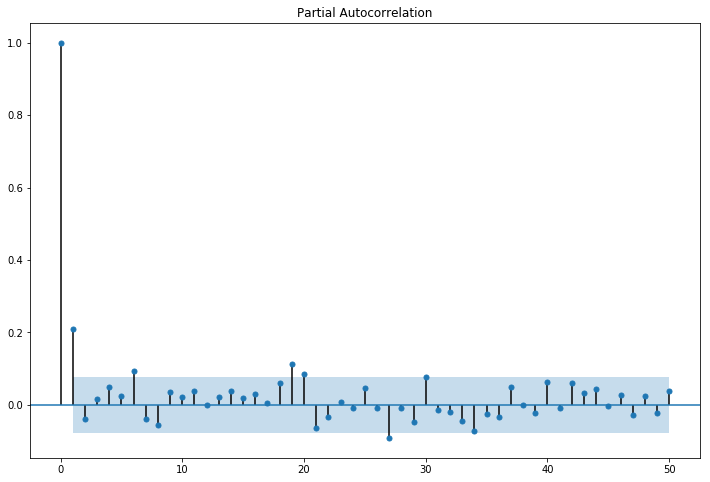

USDT_LTC
Euclidean / Ward


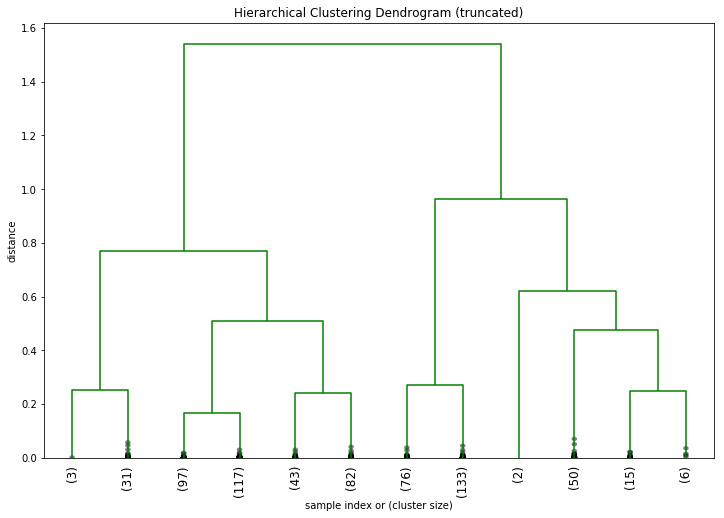

Euclidean Cophenetic Correlation Coefficient: 0.4640096859255679
Euclidean Clusters


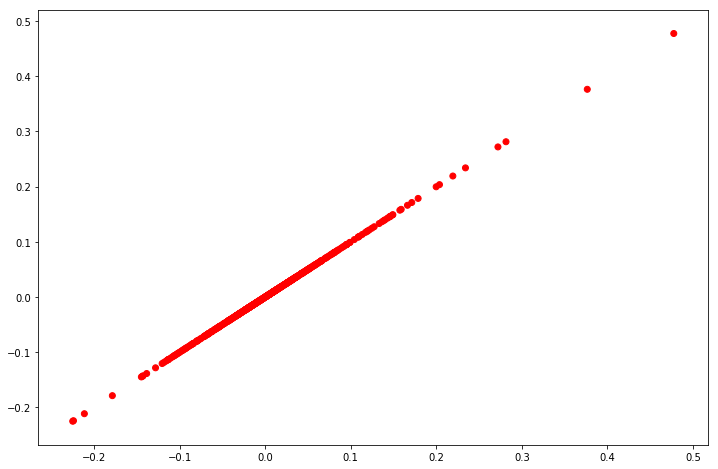

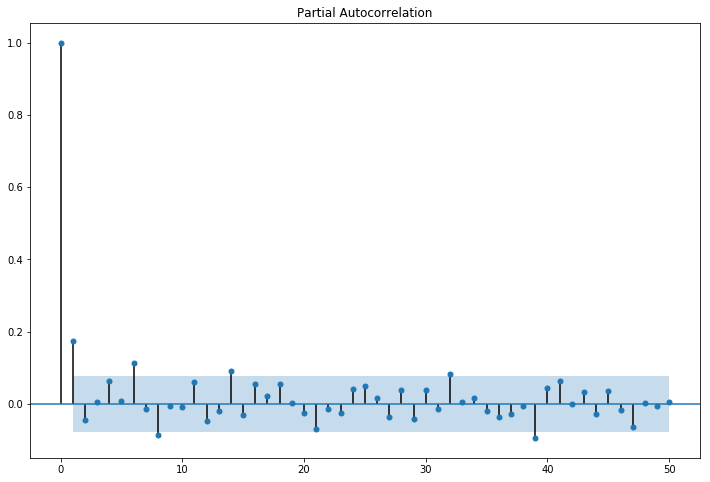

USDT_DASH
Euclidean / Ward


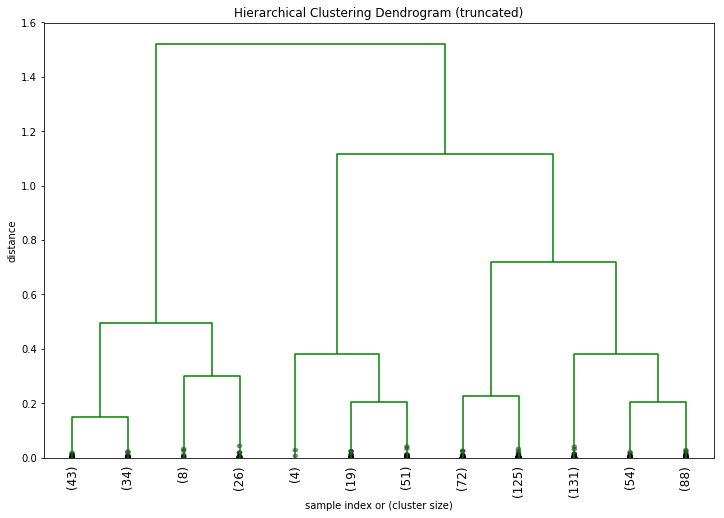

Euclidean Cophenetic Correlation Coefficient: 0.6710308495984773
Euclidean Clusters


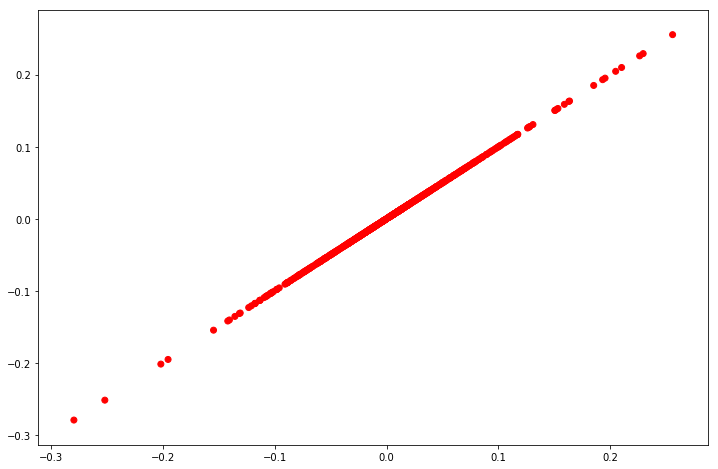

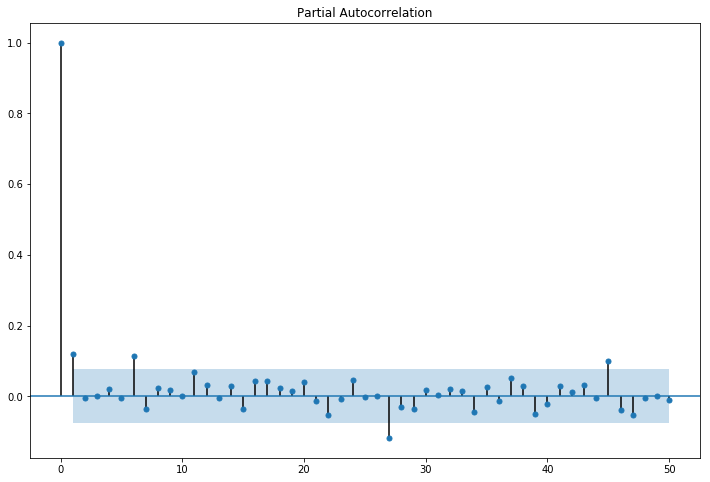

BTC_ETH
Euclidean / Ward


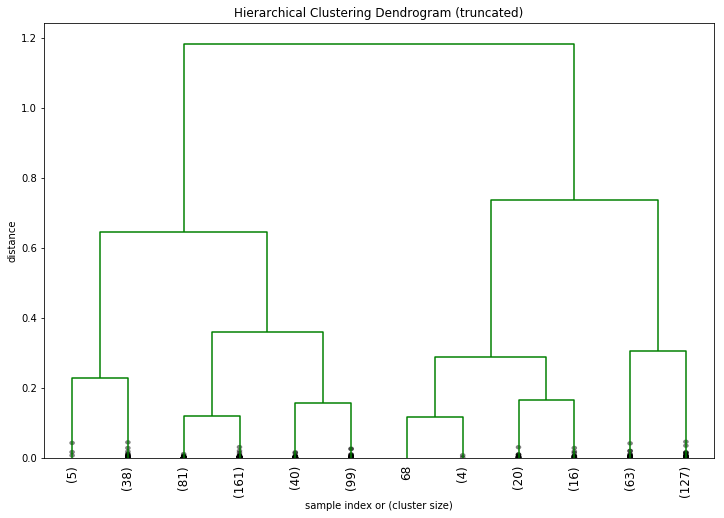

Euclidean Cophenetic Correlation Coefficient: 0.5316112701180241
Euclidean Clusters


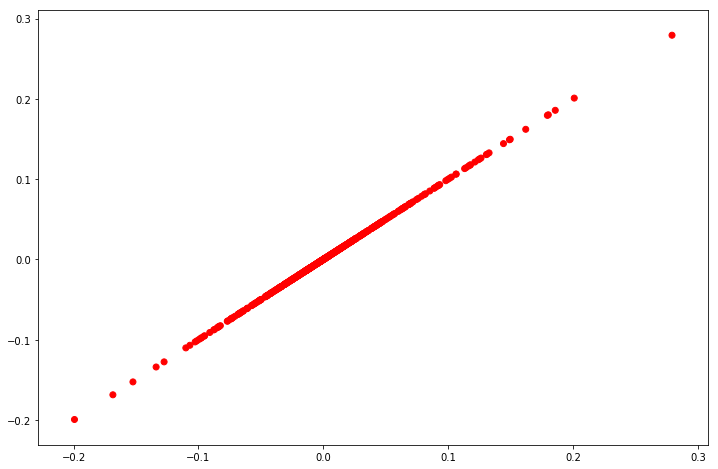

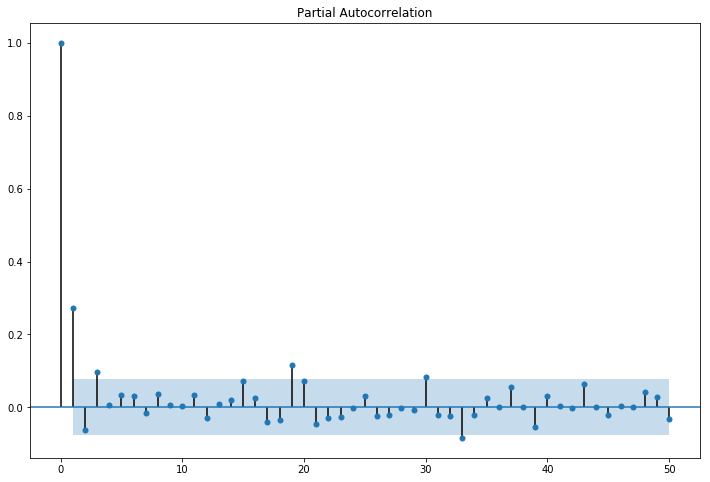

BTC_LTC
Euclidean / Ward


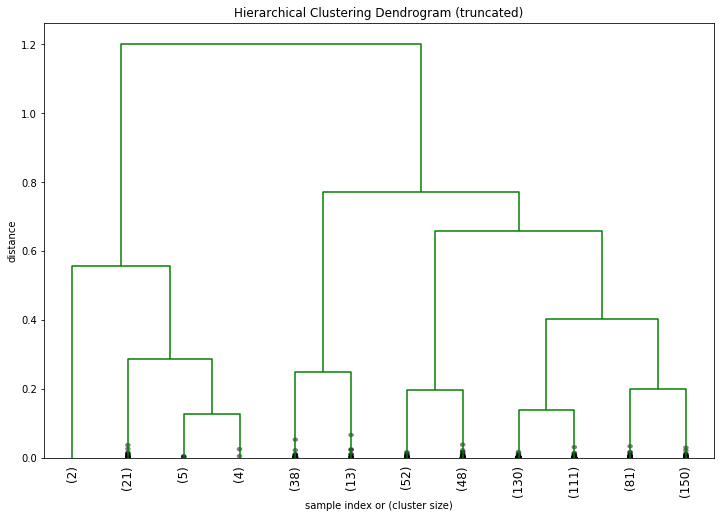

Euclidean Cophenetic Correlation Coefficient: 0.7363987790212057
Euclidean Clusters


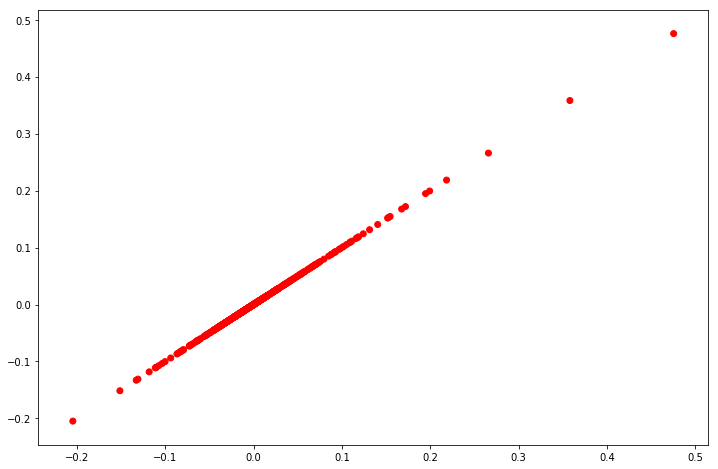

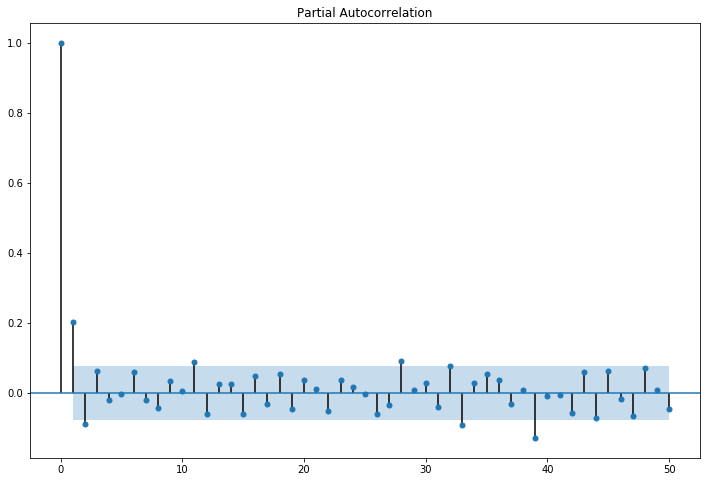

BTC_DASH
Euclidean / Ward


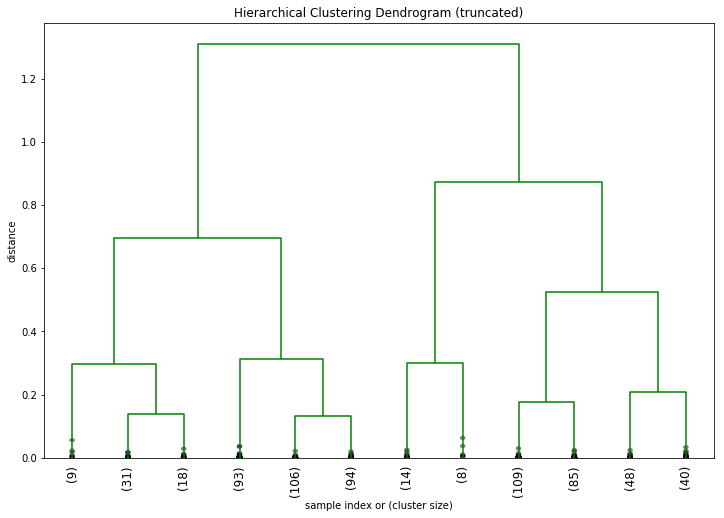

Euclidean Cophenetic Correlation Coefficient: 0.47541103348704367
Euclidean Clusters


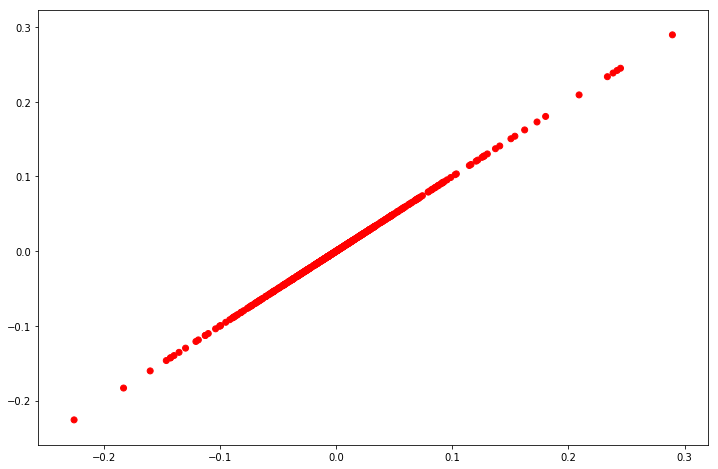

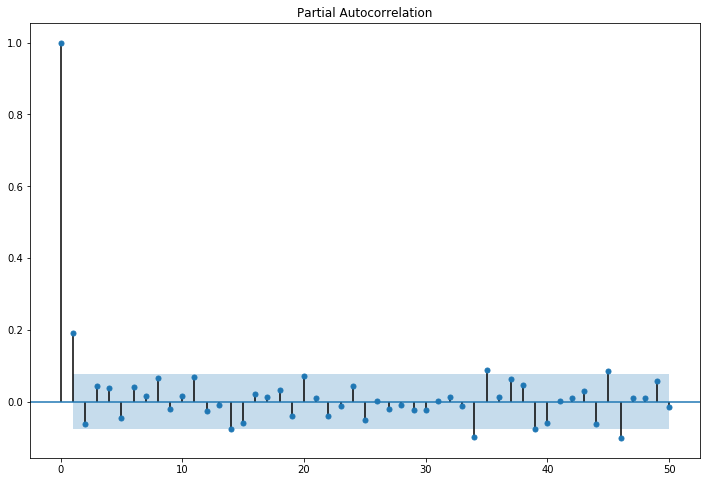

In [9]:
for series, pair in get_pairs():
    generate_clusters(series, pair)
    plot_partial_lag(series, 50)